## 7-3. Gensim을 이용한 토픽 모델링

### Gensim 사용법과 시각화
[Gensim](https://radimrehurek.com/gensim/)은 Word2Vec으로 잘 알려져 있으며, 토픽 모델링을 비롯해 의미적인 자연어 처리를 위해 다양한 라이브러리를 제공한다. Word2Vec은 워드 임베딩을 다룰 때 실습해보기로 하고, 여기서는 토픽 모델링 중에서 LDA 모형 위주로 실습해보기로 한다.

Gensim은 텍스트에 대한 토큰화 결과를 입력으로 사용한다. 따라서 먼저 20 뉴스그룹의 문서들을 다음과 같이 토큰화한다. 사이킷런과의 비교를 위해 Gensim 실습에서서도 동일한 데이터를 사용한다. 다만 토픽 모델링은 추출된 단어들을 읽고 토픽을 추정해야 하므로 편의상 스테밍은 하지 않기로 한다.

In [1]:
# ! pip install --upgrade gensim

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'comp.sys.ibm.pc.hardware', 'sci.crypt']

# 학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

In [3]:
# 필요한 library들을 import
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

cachedStopWords = stopwords.words("english")

RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) # 영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

Gensim은 먼저 토큰화 결과로부터 토큰과 gensim 모듈이 내부적으로 사용하는 id를 매칭하는 사전을 생성한다. 이를 위한 클래스가 [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html)다. 사전을 생성하면 filter_extremes() 메서드에서, 사이킷런의 max_features에 해당하는 keep_n 인수, min_df에 해당하는 no_below, max_df에 해당하는 no_above 인수를 이용해 특성을 선택할 수 있다. 사이킷런과 마찬가지로 no_below와 no_above로 출현한 문서 빈도수가 너무 낮거나 높은 단어들을 제외하고, 빈도수가 높은 순으로 keep_n에서 지정된 수의 단어를 특성으로 선택한다.

다음 단계에서는 사이컷런의 CountVectorizer와 같은 기능을 하는 doc2bow() 메서드로 토큰화된 결과를 카운트 벡터, 즉 BOW 형태로 변환한다. 이때 gensim의 용어에 매우 주의해야 한다. 우선 gensim은 내부 모듈에서 매개변수를 사용할 때 텍스트의 토큰화 결과를 공통적으로 texts로 지칭한다. 그리고 이 토큰화 결과를 doc2bow()로 변환한 결과를 지칭하는 매개변수로 corpus를 사용한다. 일반적으로 texts 혹은 corpus라고 쓰면 토큰화 이전의 raw text를 생각하기 쉽지만, gensim에서는 이와 같이 내부적으로 표현한다는 것을 잘 기억해야 실수를 피할 수 있다.

아래의 예제는 dictionary 생성, 필터링, 카운트 벡터 변환의 과정을 순서대로 보여준다.

In [4]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


Gensim에서 LDA 모델링을 수행하는 클래스는 gensim.models의 [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html)이다. 다음은 LdaModel의 매개변수와 기본값을 보여준다. 각 매개변수의 기본값이 어떻게 설정됐는지 유심히 살펴볼 필요가 있다. 예를 들어 iterations, 즉 반복횟수는 50으로 지정돼 있다.

    classgensim.models.ldamodel.LdaModel(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<class 'numpy.float32'>)

중요한 매개변수들을 살펴보면, 먼저 corpus는 앞서 설명한 바와 같이 doc2bow()를 이용해 변환된 카운트 벡터 리스트다. 앞서 생성한 corpus를 인수로 넘기면 된다. num_topics는 토픽의 수로 신중하게 결정해야 할 값이나, 일단 10으로 지정한다. id2word는 dictionary를 의미하므로 그대로 전달하면 된다.

passes는 사이킷런의 max_iter와 같다고 보면 된다. 말뭉치 전체에 대해 학습하는 횟수를 지정한다. 기본값인 1을 적용해보면 상황에 따라 결과가 잘 안 나올 때가 있으므로 안전하게 5 정도로 준다.

gensim에서 alpha는 문서의 사전 토픽분포에 대한 매개변수로, 사전 토픽분포를 직접 주거나 토픽분포를 결정하는 전략을 지정할 수 있다. 전략은 symmetric, asymmetric, auto 중에서 선택할 수 있는데, symmetric은 모든 토픽에 대해 고정된 대칭 값을 사용하는 반면, asymmetric은 토픽들에 대해 비대칭 값을 사용하며, auto는 비대칭 값을 corpus로부터 학습한다.

eta는 토픽의 사전 단어분포에 대한 매개변수로, 직접 다양한 방식으로 분포를 주거나 alpha와 같이 auto로 전략을 지정할 수 있다. 다음 실습에서는 alpha와 eta에 대해 기본값을 사용한다. 웹에서의 예제들을 살펴보면 둘 다 auto로 하는 것도 많이 볼 수 있다.

아래 예에서는 먼저 토픽의 수를 10개로 정하고, passes는 5, 그 외의 값은 기본값을 사용한다. 참고로 %time은 주피터 노트북의 명령어로, 해당 문장을 실행하는 데 소요된 시간을 출력해준다.

In [5]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

Wall time: 19 s


사이킷런에서는 각 토픽의 상위 비중 단어를 보기 위해 직접 함수를 만들었다. gensim은 이를 위해 print_topics() 메서드를 지원한다. num_topics 매개변수로 보고 싶은 토픽의 수를, num_words로 각 토픽의 상위 단어 수를 지정할 수 있다. 보통 num_words만 사용한다.

In [6]:
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

위 결과를 보면, 각 토픽의 번호와 함께 토픽의 상위 비중 단어, 비중을 함께 볼 수 있다. 사이킷런에서의 결과와 유사한 것을 볼 수 있다.

get_document_topics 메서드를 이용하면 인수로 넘긴 문서들에 대해 토픽 분포를 반환한다. 즉 인수로 corpus-BOW로 변환된 카운트 벡터를 요구하며, minimum_probability로 보여질 토픽의 비중에 대한 임곗값을 설정할 수 있다. 다시 말해서 minimum_probability 이상의 토픽만 출력되도록 할 수 있다.

In [7]:
print("# topic distribution of the first document: ", model.get_document_topics(corpus)[0])

# topic distribution of the first document:  [(0, 0.7257724), (8, 0.26994753)]


위 예는 첫째 문서에 대한 토픽 분포를 보여주는데, 결과를 보면 0에 매우 가까운 값은 출력되지 않았다. 이 결과와 사이킷런에서의 결과를 비교하면 두 라이브러리가 비슷한 결과를 보여주고 있음을 알 수 있다.

pyLDAvis는 gensim의 토픽 모델링 결과를 시각화하는 패키지이며, pip를 이용해 쉽게 설치할 수 있다. pyLDAvis를 사용할 때 가장 유의할 점은 시각화 모듈의 이름이 pyLDAvis.gensim에서 pyLDAvis.gensim.models로 바뀌었다는 것이다. 웹에서 찾을 수 있는 대부분의 예제에서는 아직도 pyLDAvis.gensim을 사용하고 있는데, 실행해보면 에러가 발생하니 주의해야 한다.

다음과 같이 model, corpus, dictionary를 인수로 넘겨주면 쉽게 시각화할 수 있다.

In [8]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

C:\Users\no1hj\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.655448
5      0.065990  0.123619       2        1  14.522807
9      0.072133  0.092872       3        1  12.987428
7      0.138320  0.043608       4        1  11.020432
4     -0.021828  0.007494       5        1   9.298342
6      0.072783 -0.094710       6        1   9.118871
3      0.027374 -0.054949       7        1   8.494179
0     -0.040788 -0.129975       8        1   4.524052
2      0.005360 -0.091971       9        1   4.051841
1     -0.182144  0.063762      10        1   3.326599, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3752.000000  3752.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.444768  1672.570764  Topic10  -5.1558   0.1469
789          sci    53.264913   309.473962  Topic10  -5.3463   1.6436
602   university    56.862628  1487.219103  Topic10  -5.2810   0.1392
294         time    55.767081  1187.715285  Topic10  -5.3004   0.3446
315       better    54.192707   564.543526  Topic10  -5.3290   1.0597

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006274      128
1359      2  0.069013      128
1359      3  0.037643      128
1359      4  0.878342      128
153       1  0.057463     1993
...     ...       ...      ...
343       8  0.022394    years
343       9  0.005599    years
343      10  0.121303    years
704       3  0.991487      zoo
705       3  0.984035  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

### 혼란도와 토픽 응집도를 이용한 최적값 선택
gensim은 혼란도와 토픽 응집도를 계산할 수 있는 모듈을 모두 제공한다. 먼저 혼란도는 LDA model의 log_perplexity() 메서드로 쉽게 구할 수 있다. 다만 model.log_perplexity(corpus)와 같이 인수로 corpus를 넘겨줘야 한다.

토픽 응집도 계산을 위해서는 [CoherenceModel 클래스](https://radimrehurek.com/gensim/models/coherencemodel.html)를 사용해야 한다. CoherenceModel 클래스의 주요 매개변수로 먼저 model이 있는데, 사전에 학습된 토픽모형을 넘겨줘야 한다. 다음 매개변수는 texts인데, 앞서 설명한 바와 같이 텍스트에 대해 토큰화가 된 결과를 인수로 넘겨준다. corpus는 현재의 카운트 벡터를 넘겨 받는다.

coherence 매개변수는 응집도를 계산하는 척도를 지정한다. 가장 속도가 빠른 척도는 u_mass이며 u_mass를 사용할 때는 corpus를 반드시 함께 줘야 한다. 그 외의 척도로 c_v, c_uci, cnpmi가 있는데, 재미있는 것은 c로 시작하는 이 척도들을 사용할 때는 반드시 texts를 넘겨줘야 한다. coherence 매개변수의 기본값은 c_v다.

topn은 각 토픽에서 사용할 상위 단어들의 수를 지정할 수 있다. 이 외에 dictionary 매개변수가 있는데, model이 있으면 굳이 지정하지 않아도 된다. 

이상의 결과를 종합해 보면 두 가지 사용법이 있는 것을 알 수 있다. u_mass를 사용할 때는 model과 corpus가 반드시 필요하고, 기본값을 포함해 c로 시작하는 척도를 사용할 때는 model과 texts가 반드시 필요하다. 이 책에서는 속도를 위해 u_mass를 사용한다.

아래 예는 CoherenceModel을 이용해 coherence를 계산한 예다.

In [9]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


이제 사이킷런에서 했듯이 혼란도와 응집도를 이용해 최적의 토픽 수를 결정하는 예를 실습한다. 지정된 토픽 수의 범위에 따라 LDA 모델을 학습하고, 이 모델에 대해 혼란도와 토픽 응집도를 계산해 그래프로 그리는 것으로, 다음과 같이 함수로 구현했다.

num_topics: 6, perplexity: -7.035, coherence: -1.701
num_topics: 7, perplexity: -7.023, coherence: -1.735
num_topics: 8, perplexity: -7.023, coherence: -1.547
num_topics: 9, perplexity: -7.007, coherence: -1.891
num_topics: 10, perplexity: -6.996, coherence: -1.888
num_topics: 11, perplexity: -7.027, coherence: -2.164
num_topics: 12, perplexity: -7.019, coherence: -2.018
num_topics: 13, perplexity: -7.025, coherence: -2.255
num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


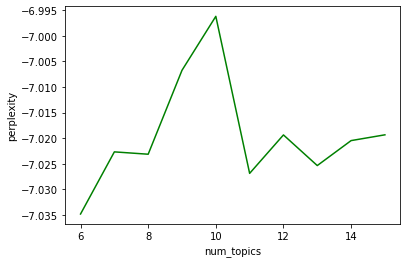

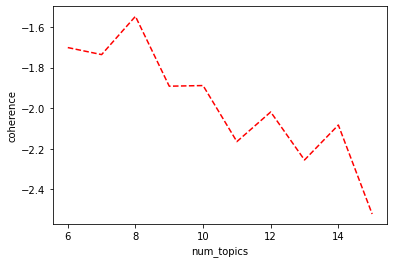

In [10]:
import matplotlib.pyplot as plt

def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

실행 결과를 보면 토픽 모델링을 최적화하는 것이 쉽지 않음을 알 수 있다. 우선 혼란도는 낮을수록 좋고 응집도는 높을수록 좋은데, 두 척도가 모두 최상인 토픽의 수는 없다. 혼란도는 토픽 수 6에서 가장 좋은 반면, 응집도는 8에서 가장 좋다. 6으로 할지 8로 할지는 결국 분석가의 결정이며, 둘 다 해보고 해석이 더 좋은 것을 선택하는 것도 대안이 될 수 있을 것이다.